In [2]:
from typing import Any, Iterator, List, Optional, Tuple
from abc import ABC, abstractmethod
import os
from concurrent.futures import ThreadPoolExecutor
import random

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp
from PIL import Image

import deepscratch
from deepscratch.dataset.base import Dataset, DataLoader

deepscratch.dataset.base


In [43]:
class ImageDataset(Dataset):
    """
    A dataset for loading images from a directory, including subdirectories.
    Labels are derived from subfolder names.
    """

    def __init__(self, directory: str, target_short: int, crop_size: int, ohe: bool = False):
        self.directory = directory
        self.target_short = target_short
        self.crop_size = crop_size
        self.ohe = ohe
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        

        # Scan directory to create a mapping of class names to indices
        classes = sorted(f for f in os.listdir(directory) if not f.startswith("."))
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = class_idx
                self.idx_to_class[class_idx] = class_name
                for root, _, files in os.walk(class_path):
                    for file in files:
                        if file.lower().endswith(("jpg", "jpeg", "png", "bmp", "tiff", "webp")):
                            self.image_paths.append(os.path.join(root, file))
                            self.labels.append(class_idx)

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Tuple[jnp.ndarray, Any]:
        image = Image.open(self.image_paths[index]).convert("RGB")
        
        # Resize: scale the image so that the shorter side is 256 pixels
        width, height = image.size
        if width < height:
            new_width = self.target_short
            new_height = int(self.target_short * height / width)
        else:
            new_height = self.target_short
            new_width = int(self.target_short * width / height)
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Random crop: extract a 224x224 patch
        if new_width > self.crop_size and new_height > self.crop_size:
            left = random.randint(0, new_width - self.crop_size)
            top = random.randint(0, new_height - self.crop_size)
            image = image.crop((left, top, left + self.crop_size, top + self.crop_size))
        else:
            # In the rare event the image is smaller than the crop size,
            # you could either resize to crop_size or center crop after padding.
            image = image.resize((self.crop_size, self.crop_size), Image.Resampling.LANCZOS)

        label = self.labels[index]
        if self.ohe:
            label = jnp.eye(len(self.class_to_idx))[label]  # One-hot encoding

        return jnp.array(image) / 255.0, label


In [47]:
class MNISTDataset(ImageDataset):
    def __init__(self, **kwargs):
        super().__init__(
            deepscratch.__path__[0] + "/../data/mnist",
            28,
            28,
            **kwargs
        )

An instance of digit: 3


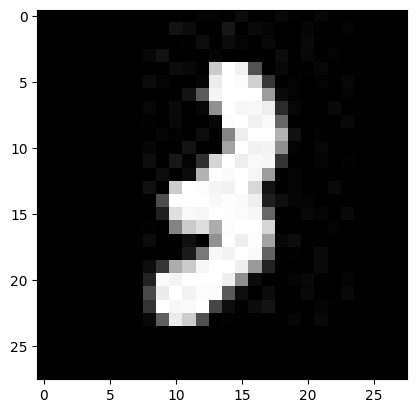

In [52]:
ds = MNISTDataset()
i = random.randint(0,len(ds))
x, y = ds[i]
print(f"An instance of digit: {ds.idx_to_class[y]}")
plt.imshow(x)

In [74]:
class ImageNet(ImageDataset):
    def __init__(self, **kwargs):
        super().__init__(
            deepscratch.__path__[0] + "/../data/imagenet/train",
            200,
            160,
            **kwargs
        )

(160, 160, 3)
An instance of class: n02979186


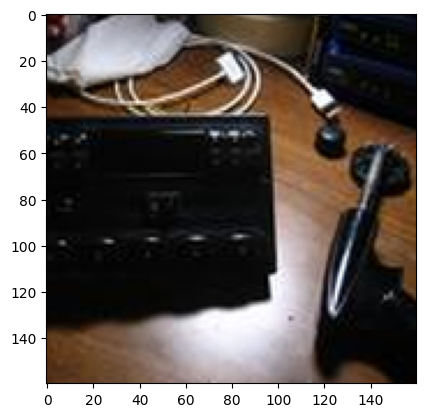

In [ ]:
ds = ImageNet()
i = random.randint(0,len(ds))
x, y = ds[i]
print(f"An instance of class: {ds.idx_to_class[y]}")
plt.imshow(x)